# Collector

> Collect elements from website 

In [ ]:
#| default_exp collector

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *
%autoreload 2

In [ ]:
#| export 
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from selenium.webdriver.common.by import By
import logging
from selenium import webdriver
from selenium.webdriver.remote.webdriver import WebDriver
import pickle
import pandas as pd
from pathlib import Path
import os

In [ ]:
#| export
webpage = "https://www.nasm.org/exercise-library" 
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

class Collector(object): 
    """Collects items from a website."""
    def __init__(self, url:str):
        self.driver = webdriver.Chrome()
        self.url = url

    def get_url(self): self.driver.get(self.url)

    def get_elements_by_css(self, css_selector: str):
        try:
            elements = self.driver.find_elements(By.CSS_SELECTOR, css_selector)
            logger.info(f"Found {len(elements)} elements with CSS selector: {css_selector}")
            return elements
        except Exception as e:
            logger.error(f"An error occurred while trying to find elements: {e}")
            return []

    def collect_data_from_elements(self, elements, css_selectors):
        data_list = []
        for element in elements:
            data = {}
            for key, selector in css_selectors.items():
                try:
                    if key=="link": 
                        data[key] = element.find_element(By.CSS_SELECTOR, selector).get_attribute('href')
                    else:
                        data[key] = element.find_element(By.CSS_SELECTOR, selector).text
                except Exception as e:
                    logger.error(f"Could not find {key} using selector {selector}: {e}")
                    data[key] = None
            data_list.append(data)
        return data_list 
        

    def get_repeating_elements(self, selector, css_selectors):
        self.elements = self.get_elements_by_css(selector)
        return self.collect_data_from_elements(self.elements, css_selectors)
        
    

In [ ]:
c = Collector(webpage)
c.get_url()

In [ ]:
selector = '#exerciseResults .course'

These are the elements to target:  


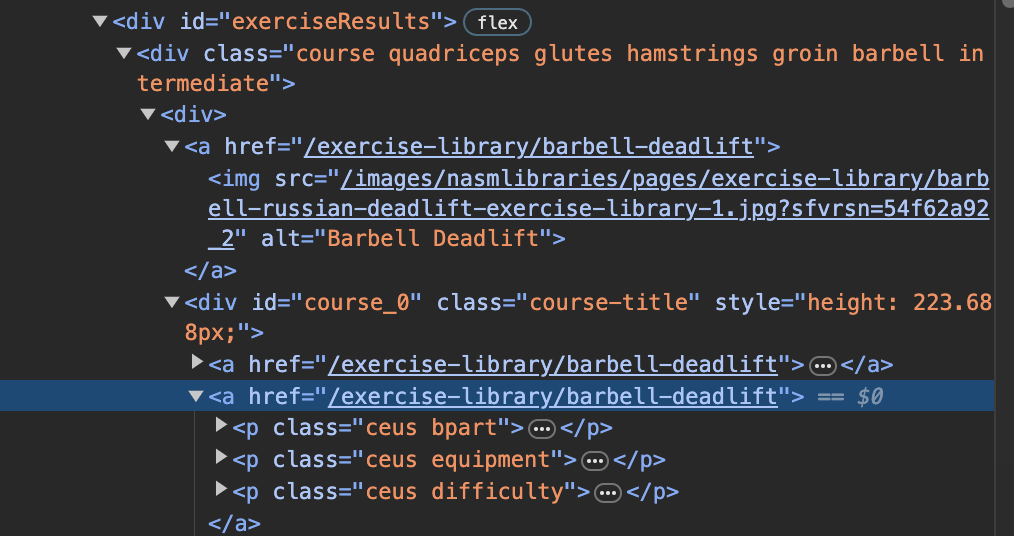

In [ ]:
css_selectors = {
    'title': 'h2.courseName',
    'body_parts': 'p.ceus.bpart span',
    'equipment': 'p.ceus.equipment span',
    'difficulty': 'p.ceus.difficulty span', 
    'link': 'div > a'
}

In [ ]:
exercises = c.get_repeating_elements(selector, css_selectors)

2023-11-15 18:29:10,254 - INFO - Found 75 elements with CSS selector: #exerciseResults .course


In [ ]:
exercises[0]

{'title': 'BARBELL DEADLIFT',
 'body_parts': 'Quadriceps, Glutes, Hamstrings, Groin',
 'equipment': 'Barbell',
 'difficulty': 'Intermediate',
 'link': 'https://www.nasm.org/exercise-library/barbell-deadlift'}

For each exercise, navigate to link and get video image
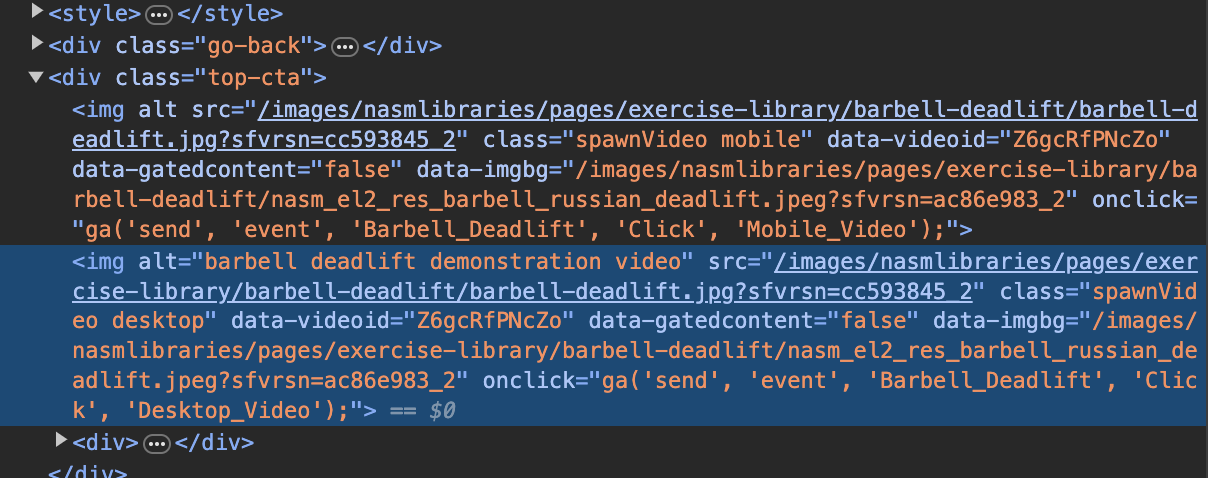

In [ ]:
class GetExcercises(Collector): 
    def get_exercises(self):
        self.exercises = self.get_repeating_elements(selector, css_selectors)
        self.get_video_ids()
        
    def get_video_ids(self): 
        for a in self.exercises: 
            self.driver.get(a['link']) 
            a['video_id'] = self.driver.find_element(
                By.CSS_SELECTOR, 'div.top-cta img:nth-of-type(2)').get_attribute('data-videoid')
            logger.info(f"video id for {a['title']} is {a['video_id']}")

    def save_exercises(self, path:str="exercises.pkl"): 
        "pickle exercise locally" 
        with Path(path).open("wb") as f: 
            pickle.dump(self.exercises, f)
        
    def load_exercises(self, path:str="exercises.pkl"):
        with Path(path).open('rb') as f: 
            self.exercises = pickle.load(f) 
        
    def prep_data(self): 
        "Preprocess data for uploading to google sheet" 
        for i,a in enumerate(self.exercises): 
            self.exercises[i]['video_link'] = f('https://www.youtube.com/watch?v={a["video_id"]}') 
    
    def load_gspread(self): 
        # Google Sheets setup 
        scope = ["https://spreadsheets.google.com/feeds",'https://www.googleapis.com/auth/spreadsheets',
         "https://www.googleapis.com/auth/drive.file","https://www.googleapis.com/auth/drive"]
        creds = ServiceAccountCredentials.from_json_keyfile_name('path/to/your/credentials.json', scope)
        client = gspread.authorize(creds)
        
    
    


In [ ]:
g = GetExcercises(webpage)
g.get_url()

In [ ]:
g.get_exercises()

2023-11-25 00:03:31,827 - INFO - Found 75 elements with CSS selector: #exerciseResults .course
2023-11-25 00:03:36,701 - INFO - video id for BARBELL DEADLIFT is Z6gcRfPNcZo
2023-11-25 00:03:38,051 - INFO - video id for KETTLEBELL DEADLIFT is LnIMaf-XOpM
2023-11-25 00:03:40,395 - INFO - video id for DUMBBELL ROMANIAN DEADLIFT is V8Hdl1FiNt4
2023-11-25 00:03:41,749 - INFO - video id for LYING LEG CURL is Dq5y4WEcqqo
2023-11-25 00:03:42,834 - INFO - video id for BARBELL BICEP CURL is pQfJR-sSIvA
2023-11-25 00:03:44,059 - INFO - video id for FLOOR BRIDGE is Z3cY3d3BBo4
2023-11-25 00:03:45,421 - INFO - video id for FLOOR PRONE COBRA is keErJXdp2lE
2023-11-25 00:03:46,813 - INFO - video id for GOOD MORNINGS is Daq-wJMUnes
2023-11-25 00:03:47,900 - INFO - video id for SIDE PLANK is 44ND4bOB-T0
2023-11-25 00:03:48,951 - INFO - video id for PLANK is mwlp75MS6Rg
2023-11-25 00:03:50,163 - INFO - video id for PLANK WALKUP is 6Tv4xTRPtUc
2023-11-25 00:03:51,235 - INFO - video id for STRAIGHT-ARM PL

In [ ]:
# reload_ext isnot working... 

for i,a in enumerate(g.exercises): 
    g.exercises[i]['video_link']=f'https://www.youtube.com/watch?v=www.youtube.com/watch?v={a["video_id"]}'

In [ ]:
g.save_exercises()

In [ ]:
g.load_exercises()

In [ ]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build
from google.oauth2 import service_account

In [ ]:
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name('/Users/User1/.gsutil/fitapp-406202-3dd8ba64c5ef.json', scope)
client = gspread.authorize(creds)

In [ ]:
sheet = client.create("fitapp_exercises").sheet1

In [ ]:
data = df.values.tolist()

In [ ]:
headers = df.columns.values.tolist()

In [ ]:
data

[['BARBELL DEADLIFT',
  'Quadriceps, Glutes, Hamstrings, Groin',
  'Barbell',
  'Intermediate',
  'https://www.nasm.org/exercise-library/barbell-deadlift',
  'Z6gcRfPNcZo'],
 ['KETTLEBELL DEADLIFT',
  'Quadriceps, Hamstrings, Groin, Glutes',
  'Kettlebell',
  'Beginner',
  'https://www.nasm.org/exercise-library/kettlebell-deadlift',
  'LnIMaf-XOpM'],
 ['DUMBBELL ROMANIAN DEADLIFT',
  'Hamstrings, Groin, Glutes',
  'Dumbbells',
  'Intermediate',
  'https://www.nasm.org/exercise-library/dumbbell-romanian-deadlift',
  'V8Hdl1FiNt4'],
 ['LYING LEG CURL',
  'Hamstrings, Calves',
  'Lying Leg Curl Machine',
  'Beginner',
  'https://www.nasm.org/exercise-library/lying-leg-curl',
  'Dq5y4WEcqqo'],
 ['BARBELL BICEP CURL',
  'Biceps',
  'Barbell',
  'Beginner',
  'https://www.nasm.org/exercise-library/barbell-bicep-curl',
  'pQfJR-sSIvA'],
 ['FLOOR BRIDGE',
  'Core, Glutes, Groin',
  'None',
  'Beginner',
  'https://www.nasm.org/exercise-library/floor-bridge',
  'Z3cY3d3BBo4'],
 ['FLOOR PRONE CO

In [ ]:
data.insert(0,headers)

In [ ]:
data

[['title', 'body_parts', 'equipment', 'difficulty', 'link', 'video_id'],
 ['BARBELL DEADLIFT',
  'Quadriceps, Glutes, Hamstrings, Groin',
  'Barbell',
  'Intermediate',
  'https://www.nasm.org/exercise-library/barbell-deadlift',
  'Z6gcRfPNcZo'],
 ['KETTLEBELL DEADLIFT',
  'Quadriceps, Hamstrings, Groin, Glutes',
  'Kettlebell',
  'Beginner',
  'https://www.nasm.org/exercise-library/kettlebell-deadlift',
  'LnIMaf-XOpM'],
 ['DUMBBELL ROMANIAN DEADLIFT',
  'Hamstrings, Groin, Glutes',
  'Dumbbells',
  'Intermediate',
  'https://www.nasm.org/exercise-library/dumbbell-romanian-deadlift',
  'V8Hdl1FiNt4'],
 ['LYING LEG CURL',
  'Hamstrings, Calves',
  'Lying Leg Curl Machine',
  'Beginner',
  'https://www.nasm.org/exercise-library/lying-leg-curl',
  'Dq5y4WEcqqo'],
 ['BARBELL BICEP CURL',
  'Biceps',
  'Barbell',
  'Beginner',
  'https://www.nasm.org/exercise-library/barbell-bicep-curl',
  'pQfJR-sSIvA'],
 ['FLOOR BRIDGE',
  'Core, Glutes, Groin',
  'None',
  'Beginner',
  'https://www.nas

In [ ]:
sheet.update('A1', data)

/var/folders/gb/kb8mnm8n3rv74ttsj3qpxmcr0000gp/T/ipykernel_46275/3551621649.py:1: DeprecationWarning: [Deprecated][in version 6.0.0]: Method signature's arguments 'range_name' and 'values' will change their order. We recommend using named arguments for minimal impact. In addition, the argument 'values' will be mandatory of type: 'List[List]'. (ex) Worksheet.update(values = [[]], range_name=) 
  sheet.update('A1', data)


{'spreadsheetId': '10YcxGrdaJKR_b_vpTu-WIdeOlTzN0tu9GvsTKwuVjkY',
 'updatedRange': 'Sheet1!A1:F76',
 'updatedRows': 76,
 'updatedColumns': 6,
 'updatedCells': 456}

In [ ]:
s = client.open('fitapp_exercises') 

In [ ]:
s.fetch_sheet_metadata()

{'spreadsheetId': '10YcxGrdaJKR_b_vpTu-WIdeOlTzN0tu9GvsTKwuVjkY',
 'properties': {'title': 'fitapp_exercises',
  'locale': 'en_US',
  'autoRecalc': 'ON_CHANGE',
  'timeZone': 'Etc/GMT',
  'defaultFormat': {'backgroundColor': {'red': 1, 'green': 1, 'blue': 1},
   'padding': {'top': 2, 'right': 3, 'bottom': 2, 'left': 3},
   'verticalAlignment': 'BOTTOM',
   'wrapStrategy': 'OVERFLOW_CELL',
   'textFormat': {'foregroundColor': {},
    'fontFamily': 'arial,sans,sans-serif',
    'fontSize': 10,
    'bold': False,
    'italic': False,
    'strikethrough': False,
    'underline': False,
    'foregroundColorStyle': {'rgbColor': {}}},
   'backgroundColorStyle': {'rgbColor': {'red': 1, 'green': 1, 'blue': 1}}},
  'spreadsheetTheme': {'primaryFontFamily': 'Arial',
   'themeColors': [{'colorType': 'TEXT', 'color': {'rgbColor': {}}},
    {'colorType': 'BACKGROUND',
     'color': {'rgbColor': {'red': 1, 'green': 1, 'blue': 1}}},
    {'colorType': 'ACCENT1',
     'color': {'rgbColor': {'red': 0.2588

In [ ]:
SERVICE_ACCOUNT_FILE = '/Users/User1/.gsutil/fitapp-406202-3dd8ba64c5ef.json'
SCOPES = ['https://www.googleapis.com/auth/drive']

In [ ]:
credentials = service_account.Credentials.from_service_account_file(
        SERVICE_ACCOUNT_FILE, scopes=SCOPES)

In [ ]:
service = build('drive', 'v3', credentials=credentials)

2023-11-24 20:00:53,358 - INFO - file_cache is only supported with oauth2client<4.0.0


In [ ]:
results = service.files().list(
    q="mimeType='application/vnd.google-apps.spreadsheet' and name = 'Your Sheet Name'",
    spaces='drive',
    fields='nextPageToken, files(id, name, parents)').execute()

In [ ]:
results

{'files': []}

In [ ]:
service.files().list().execute()

{'kind': 'drive#fileList',
 'incompleteSearch': False,
 'files': [{'kind': 'drive#file',
   'mimeType': 'application/vnd.google-apps.spreadsheet',
   'id': '10YcxGrdaJKR_b_vpTu-WIdeOlTzN0tu9GvsTKwuVjkY',
   'name': 'fitapp_exercises'}]}

In [ ]:
from google.oauth2 import service_account
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

SCOPES = ['https://www.googleapis.com/auth/drive']
SERVICE_ACCOUNT_FILE = '/Users/User1/.gsutil/fitapp-406202-3dd8ba64c5ef.json'

credentials = service_account.Credentials.from_service_account_file(
        SERVICE_ACCOUNT_FILE, scopes=SCOPES)
drive_service = build('drive', 'v3', credentials=credentials)


2023-11-24 20:09:49,068 - INFO - file_cache is only supported with oauth2client<4.0.0


In [ ]:
df.to_csv('fitapp_exercises.csv', index=False)

In [ ]:
file_metadata = {'name': 'fitapp_exercises.csv'}
media = MediaFileUpload('fitapp_exercises.csv', mimetype='text/csv')
file = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

print('File ID: %s' % file.get('id'))

File ID: 19oWvMGvGHvooZp2VzJZmwxB_DyExRC2o


In [ ]:
import google.auth
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload


def upload_basic():
  """Insert new file.
  Returns : Id's of the file uploaded

  Load pre-authorized user credentials from the environment.
  TODO(developer) - See https://developers.google.com/identity
  for guides on implementing OAuth2 for the application.
  """
  creds, _ = google.auth.default()

  try:
    # create drive api client
    service = build("drive", "v3", credentials=creds)

    file_metadata = {"name": "fitapp_exercises.csv"}
    media = MediaFileUpload("download.jpeg", mimetype="text/csv")
    # pylint: disable=maybe-no-member
    file = (
        service.files()
        .create(body=file_metadata, media_body=media, fields="id")
        .execute()
    )
    print(f'File ID: {file.get("id")}')

  except HttpError as error:
    print(f"An error occurred: {error}")
    file = None

  return file.get("id")



In [ ]:
flow = InstalledAppFlow.from_client_secrets_file(
    credentials_file, SCOPES)
creds = flow.run_local_server(port=8891)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=557043897510-ng4sqgij815a75qjkd0st1lj9h04ir8g.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8891%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.file&state=LXXLMpIufTS0NumJc2x2xsdTBOQ4lr&access_type=offline


2023-11-24 23:43:24,426 - INFO - "GET /?state=LXXLMpIufTS0NumJc2x2xsdTBOQ4lr&code=4%2F0AfJohXnanti6wC5Z0PhM87u4FvXBht_zLx_RWge3m5mz5K8mqdMSutLDukxERaQW6K56qA&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.file HTTP/1.1" 200 65


In [ ]:
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

# Define the scopes
SCOPES = ['https://www.googleapis.com/auth/drive.file']

# Load credentials from the downloaded JSON file
creds = None
credentials_file = '/Users/User1/.gsutil/client_secret_557043897510-ng4sqgij815a75qjkd0st1lj9h04ir8g.apps.googleusercontent.com.json'

In [ ]:
# The file token.json stores the user's access and refresh tokens.
# It is created automatically when the authorization flow completes for the first time.
if os.path.exists('token.json'):
    creds = Credentials.from_authorized_user_file('token.json', SCOPES)
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(credentials_file, SCOPES)
        creds = flow.run_local_server(port=0)
    with open('token.json', 'w') as token:
        token.write(creds.to_json())

In [ ]:
# Connect to the Google Drive API
service = build('drive', 'v3', credentials=creds)

# File metadata and path
file_metadata = {'name': 'fitapp_exercises.csv'}
media = MediaFileUpload('fitapp_exercises.csv', mimetype='text/csv')

# Upload the file
file = service.files().create(body=file_metadata, media_body=media, fields='id').execute()
print('File ID: %s' % file.get('id'))

2023-11-24 23:44:09,619 - INFO - file_cache is only supported with oauth2client<4.0.0


File ID: 17HT8hkgusJje9LXZMPj_Sq44R_LBdAAn


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()